**Predicting IDC in Breast Cancer Histology Images** 
* Part One: https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images/
* * Model Selection (see link above)
*  Part Two: Predict IDC in Breast Cancer
* * Model Evaluation (see below)

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

The goal of this script is to identify IDC when it is present in otherwise unlabeled histopathology images. The dataset consists of 277,524 50x50 pixel RGB digital image patches that were derived from 162 H&E-stained breast histopathology samples. These images are small patches that were extracted from digital images of breast tissue samples. The breast tissue contains many cells but only some of them are cancerous. Patches that are labeled "1" contain cells that are characteristic of invasive ductal carcinoma. For more information about the data, see https://www.ncbi.nlm.nih.gov/pubmed/27563488 and http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872.

*Step 1: Import Modules*

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# 原项目中的 Keras 相关导入被 PyTorch 替代

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image # 用于图像读取


# --- Matplotlib 中文显示配置 ---
from matplotlib import rcParams
import matplotlib.font_manager as fm

font_names = ['SimHei', 'Microsoft YaHei', 'FangSong', 'KaiTi', 'sans-serif'] 
font_path_found = None

for font_name in font_names:
    try:

        font_prop = fm.FontProperties(family=font_name)
        fm.findfont(font_prop, fallback_to_default=False) 
        
        rcParams['font.family'] = font_name
        
        font_path_found = font_name
        print(f"Matplotlib 将尝试使用字体: {font_name} 来显示中文。")
        break  
    except Exception as e:
        if font_name == font_names[-1]:
             print(f"警告: 尝试设置字体 {font_name} 失败。错误: {e}")
        else:
            print(f"信息: 字体 {font_name} 未找到或设置失败，尝试下一个。错误: {e}")

if not font_path_found:
    print("警告：未能自动找到并设置合适的中文字体 (如 SimHei, Microsoft YaHei)。")
    print("标题和标签中的中文可能无法正确显示为方块。")



rcParams['axes.unicode_minus'] = False


%matplotlib inline

Matplotlib 将尝试使用字体: SimHei 来显示中文。


*Step 2: Explore Data*

In [2]:

base_data_dir = r"E:\datasets\IDC_data"


image_path_pattern = os.path.join(base_data_dir, '**', '*.png')


print(f"正在使用的glob模式: {image_path_pattern}")

# 使用glob获取所有匹配的图像文件路径
# recursive=True 允许 '**' 匹配任意层级的目录
imagePatches = glob(image_path_pattern, recursive=True)


imagePatches = [path for path in imagePatches if os.path.isfile(path)]


# 打印找到的图像数量和前10个文件的路径以供验证
print(f"总共找到 {len(imagePatches)} 张图像补丁。")
if len(imagePatches) > 0:
    print("\n前10张图像路径示例:")
    for filename in imagePatches[0:10]:
        print(filename)
    # 验证一下最后10个，确保glob正常工作
    print("\n后10张图像路径示例 (如果总数大于10):")
    for filename in imagePatches[-10:]:
        print(filename)

else:
    print("\n警告: 未找到任何图像文件。")
 

# 检查是否有重复的路径（一般不太可能，但可以作为健全性检查）
if len(imagePatches) > 0 and len(imagePatches) != len(set(imagePatches)):
    print("\n警告: imagePatches 列表中存在重复路径！这可能意味着glob模式有问题。")

正在使用的glob模式: E:\datasets\IDC_data\**\*.png
总共找到 555048 张图像补丁。

前10张图像路径示例:
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1001_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1051_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1101_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1151_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1201_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1251_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1301_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1351_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1501_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1551_class0.png

后10张图像路径示例 (如果总数大于10):
E:\datasets\IDC_data\IDC_regular_ps50_idx5\9383\1\9383_idx5_x2001_y951_class1.png
E:\datasets\IDC_data\IDC_regular_ps50_idx5\9383\1\9383_idx5_x2051_y1001_class1.png
E:\datasets\IDC_data\IDC_regular_ps50_idx5\9383\1\9383_idx5_x2051_y1051_class1.png
E:\datasets\IDC_data\ID

In [3]:
def plotImage_fixed(image_path_to_display):
    # 检查路径是否存在
    if not os.path.exists(image_path_to_display):
        print(f"图像路径不存在: {image_path_to_display}")
        return
    
    image = cv2.imread(image_path_to_display)
    if image is None:
        print(f"无法读取图像: {image_path_to_display}")
        return
    
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(image_path_to_display)) # 显示文件名作为标题
    plt.axis('off')
    return

# 从 imagePatches 中随机选择一张图片进行展示
# 首先检查 imagePatches 是否已定义且不为空
if 'imagePatches' in locals() and imagePatches and len(imagePatches) > 0:
    example_image_path = random.choice(imagePatches)
    print(f"将显示的示例图像路径: {example_image_path}")
    plotImage_fixed(example_image_path)
else:
    print("警告: 'imagePatches' 变量未定义或为空。请确保加载图像路径的单元格已成功运行。")

将显示的示例图像路径: E:\datasets\IDC_data\12820\0\12820_idx5_x2701_y101_class0.png


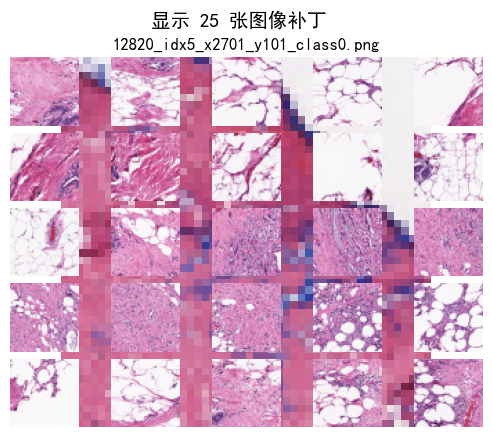

In [4]:
# Plot Multiple Images
if 'imagePatches' in locals() and imagePatches and len(imagePatches) > 0:
    bunchOfImages = imagePatches[:25] 
    
    num_images_to_plot = len(bunchOfImages)
    if num_images_to_plot == 0:
        print("没有图像可供显示。")
    else:
        cols = 5
        rows = (num_images_to_plot + cols - 1) // cols 
        
        plt.rcParams['figure.figsize'] = (10.0, 2.0 * rows) 
        plt.subplots_adjust(wspace=0.1, hspace=0.1) 
        
        valid_images_plotted = 0
        for i, l in enumerate(bunchOfImages):
            im = cv2.imread(l)
            if im is None:
                print(f"警告: 无法读取图像 {l}，跳过。")
                continue 
            
            # Check if image dimensions are valid before resize
            if im.shape[0] == 0 or im.shape[1] == 0:
                print(f"警告: 图像 {l} 尺寸无效 (shape: {im.shape})，跳过。")
                continue

            try:
                im_resized = cv2.resize(im, (50, 50))
            except cv2.error as e:
                print(f"警告: 调整图像 {l} 大小时出错: {e}，跳过。")
                continue
                
            plt.subplot(rows, cols, valid_images_plotted + 1)
            plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            valid_images_plotted += 1
            if valid_images_plotted >= rows * cols:
                 break
        
        if valid_images_plotted > 0:
            plt.suptitle(f"显示 {valid_images_plotted} 张图像补丁", fontsize=14)
            plt.show() 
        else:
            print("没有有效的图像被绘制。")

else:
    print("警告: 'imagePatches' 变量未定义或为空。请确保加载图像路径的单元格已成功运行。")


从 imagePatches 数据集中随机选择并显示的图像:


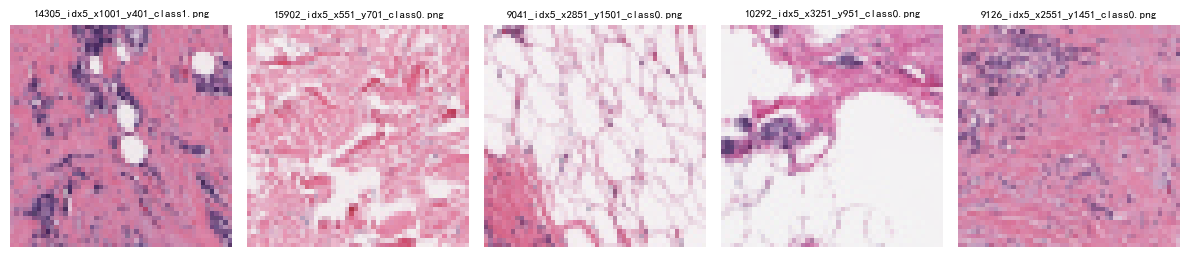

In [5]:
    # 定义一个函数来显示指定数量的随机图像
    # 这个函数现在从传入的 image_paths 列表中选择图像
    def randomImages_fixed(image_paths_list, num_images=5):
        if not image_paths_list:
            print("提供的图像路径列表为空。")
            return

        actual_num_images = min(num_images, len(image_paths_list))
        if actual_num_images == 0:
            print("没有图像可供显示。")
            return

        plt.figure(figsize=(12, 8)) 
        for i in range(actual_num_images):
            image_path_to_display = random.choice(image_paths_list)
            
            if not os.path.exists(image_path_to_display):
                print(f"图像路径不存在: {image_path_to_display}")
                ax = plt.subplot(1, actual_num_images, i + 1) 
                ax.set_title(f"路径错误:\n{os.path.basename(image_path_to_display)}", fontsize=8)
                ax.axis('off') 
                continue 

            image = cv2.imread(image_path_to_display)
            if image is None:
                print(f"无法读取图像: {image_path_to_display}")
                ax = plt.subplot(1, actual_num_images, i + 1)
                ax.set_title(f"读取错误:\n{os.path.basename(image_path_to_display)}", fontsize=8)
                ax.axis('off')
                continue

            # 将 BGR 转换为 RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            ax = plt.subplot(1, actual_num_images, i + 1)
            ax.imshow(image_rgb)
            ax.set_title(os.path.basename(image_path_to_display), fontsize=8) 
            ax.axis('off') # 关闭坐标轴，使图像更清晰

        plt.tight_layout()
        plt.show()


    print("========================================================")
    print("从 imagePatches 数据集中随机选择并显示的图像:")
    print("========================================================")
    if imagePatches: # 确保 imagePatches 不是空的
        randomImages_fixed(imagePatches, num_images=5) 
    else:
        print("imagePatches 列表为空，无法显示随机图像。")

*Step 3: Preprocess Data*

In [6]:
# 从 imagePatches 中分离图像路径到 classZero (IDC-) 和 classOne (IDC+)
# classZero 包含所有父文件夹名为 '0' 的图像路径
# classOne 包含所有父文件夹名为 '1' 的图像路径
classZero = []
classOne = []
for img_path in imagePatches:
    class_folder_name = os.path.basename(os.path.dirname(img_path))
    if class_folder_name == '0':
        classZero.append(img_path)
    elif class_folder_name == '1':
        classOne.append(img_path)

print(f"图像总数: {len(imagePatches)}")
print(f"IDC 阴性 (Class 0) 图像数量: {len(classZero)}")
print(f"IDC 阳性 (Class 1) 图像数量: {len(classOne)}")

# 验证一下，确保所有图像都被分类了
if len(imagePatches) == len(classZero) + len(classOne):
    print("所有图像都已成功分类到 classZero 或 classOne。")
else:
    print("警告：部分图像未能成功分类，请检查路径和逻辑。")


print("\nclassZero 样本路径:")
for i in range(min(3, len(classZero))): 
    print(classZero[i])

print("\nclassOne 样本路径:")
for i in range(min(3, len(classOne))):
    print(classOne[i])

图像总数: 555048
IDC 阴性 (Class 0) 图像数量: 397476
IDC 阳性 (Class 1) 图像数量: 157572
所有图像都已成功分类到 classZero 或 classOne。

classZero 样本路径:
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1001_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1051_class0.png
E:\datasets\IDC_data\10253\0\10253_idx5_x1001_y1101_class0.png

classOne 样本路径:
E:\datasets\IDC_data\10253\1\10253_idx5_x501_y351_class1.png
E:\datasets\IDC_data\10253\1\10253_idx5_x501_y401_class1.png
E:\datasets\IDC_data\10253\1\10253_idx5_x551_y301_class1.png


从 IDC 阴性 (Class 0) 类别中随机选择的图像:


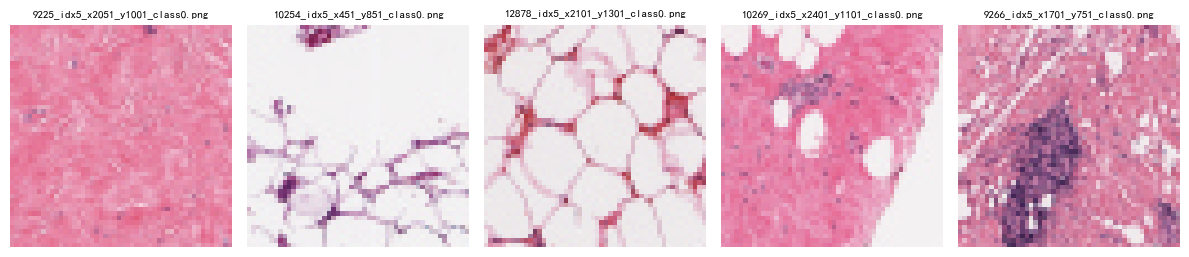


从 IDC 阳性 (Class 1) 类别中随机选择的图像:


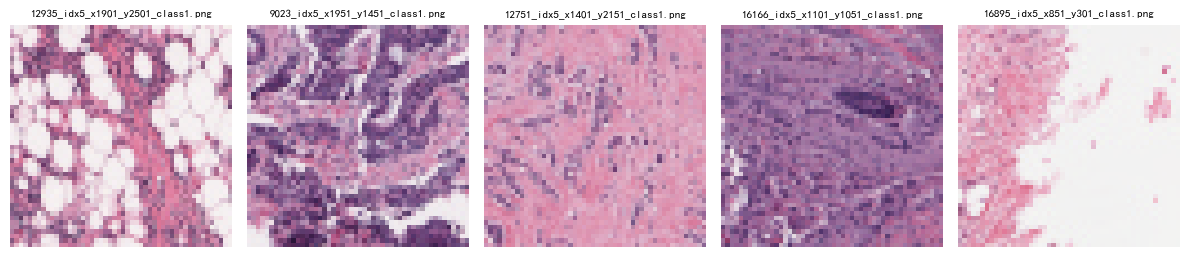

In [7]:
print("==============================================")
print("从 IDC 阴性 (Class 0) 类别中随机选择的图像:")
print("==============================================")

if classZero:
    randomImages_fixed(classZero, num_images=5)
else:
    print("IDC 阴性 (Class 0) 图像列表为空。")

print("\n==============================================")
print("从 IDC 阳性 (Class 1) 类别中随机选择的图像:")
print("==============================================")

if classOne:
    randomImages_fixed(classOne, num_images=5)
else:
    print("IDC 阳性 (Class 1) 图像列表为空。")

DataFrame 创建完成。总共包含 555048 张图像。
其中 IDC 阴性 (Class 0) 图像数量: 397476
其中 IDC 阳性 (Class 1) 图像数量: 157572

DataFrame 的前5行:
                                          image_path  target
0  E:\datasets\IDC_data\10292\0\10292_idx5_x1901_...       0
1  E:\datasets\IDC_data\10272\0\10272_idx5_x2001_...       0
2  E:\datasets\IDC_data\16551\0\16551_idx5_x3201_...       0
3  E:\datasets\IDC_data\15903\0\15903_idx5_x451_y...       0
4  E:\datasets\IDC_data\9076\0\9076_idx5_x1951_y5...       0

目标类别分布:
target
0    397476
1    157572
Name: count, dtype: int64

目标类别分布图:


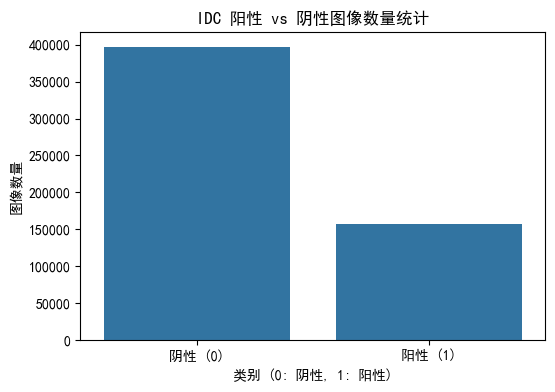

In [8]:
# 步骤 3: 创建包含图像路径和目标标签的 DataFrame

# 我们已经将图像路径分类到 classZero (IDC-) 和 classOne (IDC+)
# 目标编码: 0 代表 Non-IDC (阴性), 1 代表 IDC (阳性)

data_list = []
for img_path in classZero:
    data_list.append({'image_path': img_path, 'target': 0})
for img_path in classOne:
    data_list.append({'image_path': img_path, 'target': 1})


df = pd.DataFrame(data_list)

# 随机打乱 DataFrame 
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"DataFrame 创建完成。总共包含 {len(df)} 张图像。")
print(f"其中 IDC 阴性 (Class 0) 图像数量: {len(classZero)}")
print(f"其中 IDC 阳性 (Class 1) 图像数量: {len(classOne)}")

print("\nDataFrame 的前5行:")
print(df.head())

print("\n目标类别分布:")
print(df['target'].value_counts())

print("\n目标类别分布图:")
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('IDC 阳性 vs 阴性图像数量统计')
plt.xlabel('类别 (0: 阴性, 1: 阳性)')
plt.ylabel('图像数量')
plt.xticks([0, 1], ['阴性 (0)', '阳性 (1)'])
plt.show()

Step 4: Creation of The Training and Validation Sets

In [9]:
from sklearn.model_selection import train_test_split


# 打印原始DataFrame的形状
print(f"原始 DataFrame (df) 的形状: {df.shape}")
print(f"原始 DataFrame 类别分布:\n{df['target'].value_counts(normalize=True)}")
print("-" * 30)

# 第一步：将数据分为训练+验证集 (85%) 和测试集 (15%)
paths = df['image_path']
labels = df['target']

train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    paths, labels, test_size=0.15, random_state=42, stratify=labels
)


test_df = pd.DataFrame({'image_path': test_paths, 'target': test_labels})

# 第二步：将训练+验证集分为训练集 (约占总体的70%) 和验证集 (约占总体的15%)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=(0.15/0.85), random_state=42, stratify=train_val_labels
)

train_df = pd.DataFrame({'image_path': train_paths, 'target': train_labels})
val_df = pd.DataFrame({'image_path': val_paths, 'target': val_labels})

print(f"训练集 (train_df) 的形状: {train_df.shape}")
print(f"训练集类别分布:\n{train_df['target'].value_counts(normalize=True)}")
print("-" * 30)

print(f"验证集 (val_df) 的形状: {val_df.shape}")
print(f"验证集类别分布:\n{val_df['target'].value_counts(normalize=True)}")
print("-" * 30)

print(f"测试集 (test_df) 的形状: {test_df.shape}")
print(f"测试集类别分布:\n{test_df['target'].value_counts(normalize=True)}")
print("-" * 30)

# 验证总体比例
total_samples = len(df)
print(f"总样本数: {total_samples}")
print(f"训练集样本数: {len(train_df)} (占总体的 {len(train_df)/total_samples:.2%})")
print(f"验证集样本数: {len(val_df)} (占总体的 {len(val_df)/total_samples:.2%})")
print(f"测试集样本数: {len(test_df)} (占总体的 {len(test_df)/total_samples:.2%})")


原始 DataFrame (df) 的形状: (555048, 2)
原始 DataFrame 类别分布:
target
0    0.716111
1    0.283889
Name: proportion, dtype: float64
------------------------------
训练集 (train_df) 的形状: (388532, 2)
训练集类别分布:
target
0    0.716111
1    0.283889
Name: proportion, dtype: float64
------------------------------
验证集 (val_df) 的形状: (83258, 2)
验证集类别分布:
target
0    0.716111
1    0.283889
Name: proportion, dtype: float64
------------------------------
测试集 (test_df) 的形状: (83258, 2)
测试集类别分布:
target
0    0.716111
1    0.283889
Name: proportion, dtype: float64
------------------------------
总样本数: 555048
训练集样本数: 388532 (占总体的 70.00%)
验证集样本数: 83258 (占总体的 15.00%)
测试集样本数: 83258 (占总体的 15.00%)


In [10]:
#更新 IDCDataset 类定义
class IDCDataset(Dataset):
    def __init__(self, df, transform=None):
        if not isinstance(df, pd.DataFrame):
            raise ValueError("df 参数必须是一个 Pandas DataFrame。")
        if 'image_path' not in df.columns or 'target' not in df.columns:
            raise ValueError("DataFrame 必须包含 'image_path' 和 'target' 列。")
            
        self.df = df
        self.transform = transform
        # .values 
        self.image_paths = df['image_path'].values 
        self.labels = df['target'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx): 
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            # 使用 Pillow (PIL) 读取图像，并确保它是RGB格式
            image = Image.open(img_path).convert('RGB') 
        except FileNotFoundError:
            print(f"错误：图像文件未找到于路径 {img_path}")
            raise FileNotFoundError(f"图像文件未找到于路径 {img_path}")
        except Exception as e:
            print(f"读取图像 {img_path} 时发生错误: {e}")
            raise e

        if self.transform:
            image = self.transform(image)
        

        return image, torch.tensor(label, dtype=torch.long)

In [11]:
#定义数据转换 (Transforms) 和创建 Dataset 与 DataLoader 实例
import torchvision.transforms as T
from torch.utils.data import DataLoader

# 图像参数
IMG_SIZE = 50  
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

# 1. 定义数据转换 (Transforms)
# 训练集转换：包含数据增强
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),       # 调整大小
    #T.RandomHorizontalFlip(p=0.5),      # 随机水平翻转
    #T.RandomVerticalFlip(p=0.5),        # 随机垂直翻转
    #T.RandomRotation(degrees=(-30, 30)),# 随机旋转
    #T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05), # 色彩抖动
    #T.ElasticTransform(alpha=50.0, sigma=5.0), #弹性变换
    T.ToTensor(),                         
    T.Normalize(mean=mean_nums, std=std_nums) 
])

# 验证集和测试集转换
val_test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=mean_nums, std=std_nums)
])

# 2. 创建 Dataset 实例
if 'train_df' in locals() and 'val_df' in locals() and 'test_df' in locals():
    train_dataset = IDCDataset(df=train_df, transform=train_transform)
    val_dataset = IDCDataset(df=val_df, transform=val_test_transform)
    test_dataset = IDCDataset(df=test_df, transform=val_test_transform)

    print(f"训练集 Dataset 大小: {len(train_dataset)}")
    print(f"验证集 Dataset 大小: {len(val_dataset)}")
    print(f"测试集 Dataset 大小: {len(test_dataset)}")
    print("-" * 30)

    # 3. 创建 DataLoader 实例
    BATCH_SIZE = 64  
    NUM_WORKERS = 1  

    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,       
        num_workers=NUM_WORKERS, 
        pin_memory=True     
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,      
        num_workers=NUM_WORKERS, 
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=NUM_WORKERS, 
        pin_memory=True
    )

    print(f"训练集 DataLoader: {len(train_loader)} 个批次，每批大小 {BATCH_SIZE}")
    print(f"验证集 DataLoader: {len(val_loader)} 个批次，每批大小 {BATCH_SIZE}")
    print(f"测试集 DataLoader: {len(test_loader)} 个批次，每批大小 {BATCH_SIZE}")
    print("-" * 30)
    
else:
    print("错误：train_df, val_df, 或 test_df 未在环境中找到。请确保已成功运行数据分割单元格。")


训练集 Dataset 大小: 388532
验证集 Dataset 大小: 83258
测试集 Dataset 大小: 83258
------------------------------
训练集 DataLoader: 6071 个批次，每批大小 64
验证集 DataLoader: 1301 个批次，每批大小 64
测试集 DataLoader: 1301 个批次，每批大小 64
------------------------------


Step 5: Model Design and Implementation

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

#默认使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"将使用设备: {device}")

IMG_SIZE = 50

def get_resnet_model(num_classes=2, pretrained=True):
    # 加载预训练的 ResNet18 模型

    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    
    # 获取 ResNet18 最后全连接层的输入特征数
    num_ftrs = model.fc.in_features
    
    # 输出2个类别 (IDC- 和 IDC+)
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

# 创建模型实例并将其移动到GPU 
model1 = get_resnet_model(num_classes=2, pretrained=True)
model1 = model1.to(device)

# 打印模型结构摘要
from torchsummary import summary
if device.type == 'cuda':
    summary(model1, input_size=(3, IMG_SIZE, IMG_SIZE)) # IMG_SIZE 应该已在前面定义
else:
    print("未安装 torchsummary 或在 CPU 上，跳过模型摘要打印。")
    print("模型结构预览 (仅最后几层):")
    for name, child in list(model1.named_children())[-3:]:
        print(name, child)
    print("...")
    print("fc", model1.fc)

# 初步测试模型是否可以处理一批数据
if 'train_loader' in locals() and train_loader is not None:
    print("开始初步模型测试...")
    try:
        import time # 确保导入time模块
        
        print("尝试从 train_loader 获取一批数据...")
        start_time_loader = time.time()
        sample_images, sample_labels = next(iter(train_loader)) # 获取图像和标签
        end_time_loader = time.time()
        print(f"获取数据耗时: {end_time_loader - start_time_loader:.2f} 秒")
        print(f"获取到的图像批次形状: {sample_images.shape}, 标签批次形状: {sample_labels.shape}")

        print(f"将数据移至设备 ({device})...")
        start_time_to_device = time.time()
        sample_images = sample_images.to(device)
        sample_labels = sample_labels.to(device) 
        end_time_to_device = time.time()
        print(f"数据移至设备耗时: {end_time_to_device - start_time_to_device:.2f} 秒")

        print("模型进行前向传播...")
        start_time_forward = time.time()
        output = model1(sample_images)
        end_time_forward = time.time()
        print(f"前向传播耗时: {end_time_forward - start_time_forward:.2f} 秒")

        print(f"模型输出形状: {output.shape}") # 应为 (BATCH_SIZE, num_classes)
        print("初步模型测试完成。")
        
    except Exception as e:
        print(f"测试模型前向传播时出错: {e}")
else:
    print("train_loader 未定义或为 None，跳过模型初步测试。")

将使用设备: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]           9,408
       BatchNorm2d-2           [-1, 64, 25, 25]             128
              ReLU-3           [-1, 64, 25, 25]               0
         MaxPool2d-4           [-1, 64, 13, 13]               0
            Conv2d-5           [-1, 64, 13, 13]          36,864
       BatchNorm2d-6           [-1, 64, 13, 13]             128
              ReLU-7           [-1, 64, 13, 13]               0
            Conv2d-8           [-1, 64, 13, 13]          36,864
       BatchNorm2d-9           [-1, 64, 13, 13]             128
             ReLU-10           [-1, 64, 13, 13]               0
       BasicBlock-11           [-1, 64, 13, 13]               0
           Conv2d-12           [-1, 64, 13, 13]          36,864
      BatchNorm2d-13           [-1, 64, 13, 13]             128
             ReLU-14       

In [13]:
import torch.optim as optim
from tqdm.auto import tqdm 
import time
import copy 

if 'device' not in locals() or 'model1' not in locals():
    print("错误: 'device' 或 'model1' 未定义。")

else:
    # 1. 定义损失函数
    # 查阅资料后得知 CrossEntropyLoss 适用于多分类。它内部包含了 Softmax，所以模型输出层不需要显式添加 Softmax
    criterion = nn.CrossEntropyLoss()

    # 2. 定义优化器 Adam
    optimizer = optim.Adam(model1.parameters(), lr=0.001)

    # 学习率调度器：在训练过程中动态调整学习率
    from torch.optim.lr_scheduler import StepLR
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    print("损失函数和优化器已定义。")

    # 3. 定义训练一个 epoch 的函数
    def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch_num, total_epochs):
        model.train()  
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        # 使用tqdm显示进度条
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_num+1}/{total_epochs} [Training]", leave=False)
        
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # 清除梯度
            
            outputs = model(inputs)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
            
            loss.backward()  # 反向传播
            optimizer.step()  # 更新权重
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1) # 获取预测结果
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            
            # 更新进度条的后缀信息
            progress_bar.set_postfix(loss=loss.item(), acc=f"{(correct_predictions.double()/total_samples):.4f}")
            
        epoch_loss = running_loss / total_samples
        epoch_acc = correct_predictions.double() / total_samples
        
        return epoch_loss, epoch_acc

    # 4. 定义评估模型的函数
    def evaluate_model(model, dataloader, criterion, device, epoch_num, total_epochs):
        model.eval()  # 将模型设置为评估模式
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch_num+1}/{total_epochs} [Validation]", leave=False)
        
        with torch.no_grad():  # 在评估模式下，不计算梯度
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

                progress_bar.set_postfix(loss=loss.item(), acc=f"{(correct_predictions.double()/total_samples):.4f}")

        epoch_loss = running_loss / total_samples
        epoch_acc = correct_predictions.double() / total_samples
        
        return epoch_loss, epoch_acc

    print("训练和评估辅助函数已定义。")


损失函数和优化器已定义。
训练和评估辅助函数已定义。


In [15]:
import time
import copy
import matplotlib.pyplot as plt 

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_save_path="best_model.pth"):
    print(f"开始训练模型，共 {num_epochs} 个周期，在 {device} 上进行...")
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    start_time_total_train = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # 训练阶段
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item()) # .item() to get Python number from tensor
        
        # 评估阶段
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device, epoch, num_epochs)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        
        epoch_duration = time.time() - epoch_start_time
        
        print(f"周期 {epoch+1}/{num_epochs} 完成 - "
              f"耗时: {epoch_duration:.2f}s - "
              f"训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f} - "
              f"验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.4f}")
        
        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), model_save_path)
            print(f"    新的最佳模型已保存到 {model_save_path} (验证准确率: {best_acc:.4f})")
            
        # 添加了学习率调度器，在这里调用 scheduler.step()
        if lr_scheduler:
            lr_scheduler.step()

    total_train_time = time.time() - start_time_total_train
    print(f"训练完成！总耗时: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s")
    print(f"最佳验证准确率: {best_acc:.4f}")
    
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model, history

print("主训练函数 'train_model' 已定义。")

# --- 准备开始训练 ---
# 设置训练参数
NUM_EPOCHS = 3  # 先用较少的周期数进行测试，后续再增加
MODEL_SAVE_PATH = "resnet18_idc_best.pth"


if 'model1' in locals() and \
   'train_loader' in locals() and train_loader is not None and \
   'val_loader' in locals() and val_loader is not None and \
   'criterion' in locals() and \
   'optimizer' in locals() and \
   'device' in locals():
    
    print("\n开始使用 ResNet18 模型进行训练...")
    model1_trained, history1 = train_model(
        model1, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        NUM_EPOCHS, 
        device,
        MODEL_SAVE_PATH
    )
    print("ResNet18 模型训练结束。")

else:
    print("错误：一个或多个训练组件 (model1, train_loader, val_loader, criterion, optimizer, device) 未定义。请确保所有之前的单元格都已成功运行。")


主训练函数 'train_model' 已定义。

开始使用 ResNet18 模型进行训练...
开始训练模型，共 3 个周期，在 cuda 上进行...


Epoch 1/3 [Training]:   0%|          | 0/6071 [00:00<?, ?it/s]

KeyboardInterrupt: 